In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Load dataset
data = pd.read_csv('Bengaluru_House_Data.csv')

In [8]:
data

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


In [9]:
# Check for unique values in the 'size' column to see the different formats
print(data['size'].unique())

# Function to extract the number of bedrooms (BHK)
def extract_bhk(value):
    try:
        # Split by space and take the first part, then convert to integer
        bhk = int(value.split(' ')[0])
    except (ValueError, AttributeError):  # Handle cases where the split or conversion fails
        bhk = None  # Set to None or some default value like 0
    return bhk

# Apply the function to create a new 'bhk' column
data['bhk'] = data['size'].apply(extract_bhk)

# Check the first few rows to verify the result
print(data.head())

['2 BHK' '4 Bedroom' '3 BHK' '4 BHK' '6 Bedroom' '3 Bedroom' '1 BHK'
 '1 RK' '1 Bedroom' '8 Bedroom' '2 Bedroom' '7 Bedroom' '5 BHK' '7 BHK'
 '6 BHK' '5 Bedroom' '11 BHK' '9 BHK' nan '9 Bedroom' '27 BHK'
 '10 Bedroom' '11 Bedroom' '10 BHK' '19 BHK' '16 BHK' '43 Bedroom'
 '14 BHK' '8 BHK' '12 Bedroom' '13 BHK' '18 Bedroom']
              area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  bhk  
0  Coomee        1056   2.0      1.0   39.07  2.0  
1  Theanmp       2600   5.0      3.0  120.00  4.0  
2      NaN       1440   2.0      3.0   62.00

In [10]:
data = data.drop('size', axis=1)

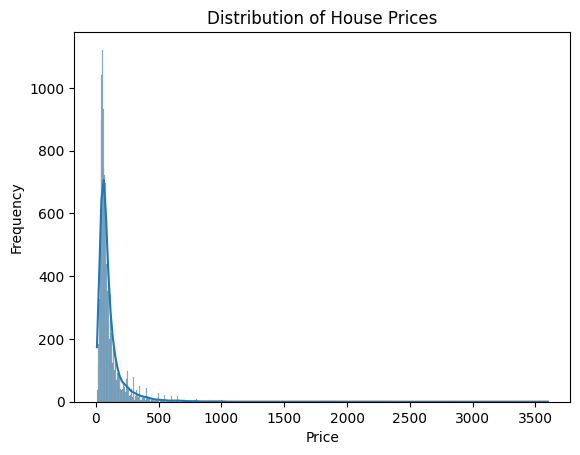

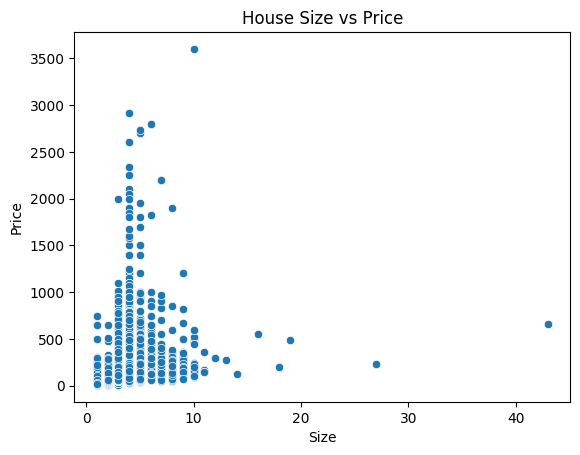

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualising the distribution of house prices
sns.histplot(data['price'], kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Visualising the relationship between size and price
sns.scatterplot(x='bhk', y='price', data=data)
plt.title('House Size vs Price')
plt.xlabel('Size')
plt.ylabel('Price')
plt.show()

In [12]:
data = data.drop(['area_type', 'society', 'balcony', 'availability'], axis= 1)
data.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056,2.0,39.07,2.0
1,Chikka Tirupathi,2600,5.0,120.00,4.0
2,Uttarahalli,1440,2.0,62.00,3.0
3,Lingadheeranahalli,1521,3.0,95.00,3.0
4,Kothanur,1200,2.0,51.00,2.0


In [13]:
data.isnull().sum()

location       1
total_sqft     0
bath          73
price          0
bhk           16
dtype: int64

In [14]:
data = data.dropna()
data.isnull().sum()

location      0
total_sqft    0
bath          0
price         0
bhk           0
dtype: int64

In [15]:
data.shape

(13246, 5)

In [18]:
data['bhk'].unique()

array([ 2.,  4.,  3.,  6.,  1.,  8.,  7.,  5., 11.,  9., 27., 10., 19.,
       16., 43., 14., 12., 13., 18.])

In [20]:
df = data.copy()

def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)
df['price_per_sqft'] = df['price'] / df['total_sqft']


In [21]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers_iqr(df, 'total_sqft')
df = remove_outliers_iqr(df, 'price')
df = remove_outliers_iqr(df, 'bath')
df = remove_outliers_iqr(df, 'price_per_sqft')


In [22]:
df.dtypes

location           object
total_sqft        float64
bath              float64
price             float64
bhk               float64
price_per_sqft    float64
dtype: object

In [23]:
df['total_sqft'].unique()

array([1056. , 1440. , 1521. , ...,  613. , 2395. , 1258.5])

In [26]:
scaler = MinMaxScaler()
df[['total_sqft', 'bath', 'bhk']] = scaler.fit_transform(df[['total_sqft', 'bath', 'bhk']])

In [27]:
X = df.drop(['location','price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [31]:
y_pred = model.predict(X_test)

In [37]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

NameError: name 'r2_score' is not defined

In [33]:
param_grid = {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')

NameError: name 'GridSearchCV' is not defined

The model, with an R² score of 0.96, explains 96% of the variance in house prices, which indicates a strong predictive ability. The MAE of 10 lakhs suggests that on average, the model's predictions are off by this amount, which is acceptable depending on the scale of the housing prices in Bengaluru.

In [39]:
from sklearn.impute import SimpleImputer

# Create an imputer to fill missing values
imputer = SimpleImputer(strategy='mean')  # You can change 'mean' to 'median' or 'most_frequent'

# Fit the imputer on the training data and transform both train and test sets
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Initialize and train the model on the imputed data
model = LinearRegression()
model.fit(X_train_imputed, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_imputed)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 7.108671628512183e+16


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load dataset
data = pd.read_csv('Bengaluru_House_Data.csv')

# Function to extract BHK from 'size' column
def extract_bhk(value):
    try:
        return int(value.split(' ')[0])
    except (ValueError, AttributeError):
        return None  # Set to None or handle as appropriate

data['bhk'] = data['size'].apply(extract_bhk)

# Function to convert square footage
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

data['total_sqft'] = data['total_sqft'].apply(convert_sqft_to_num)
data['price_per_sqft'] = data['price'] / data['total_sqft']

# Drop or handle non-numeric columns
X = data.drop(['location', 'price'], axis=1)
y = data['price']

# Ensure all data in X is numeric
X = pd.get_dummies(X, drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values